In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchmetrics.classification import MultilabelAccuracy,MultilabelAUROC, MultilabelPrecision, MultilabelF1Score, MultilabelRecall
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import torch
import numpy as np

c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\torch\onnx\_internal\_beartype.py:36: UserWarning: module 'beartype.roar' has no attribute 'BeartypeDecorHintPep585DeprecationWarning'
  warnings.warn(f"{e}")


In [2]:
import pickle

with open("separated_combined_results_mistral", "rb") as f:
    mistral_separated_combined_results = pickle.load(f)

with open("separated_combined_results", "rb") as f:
    llama3_separated_combined_results = pickle.load(f)


from graphrag_for_all.generators.community_reports_extractor import clean_and_parse_json
mistral_keywords_json = clean_and_parse_json(
    mistral_separated_combined_results["refined_keyword"].output
)
mistral_keywords_json = {   
    f"Augmented_{k}": v
    for k, v in mistral_keywords_json.items()
}
llama3_keywords_json = clean_and_parse_json(    
    llama3_separated_combined_results["refined_keyword"].output
)
llama3_keywords_json = {
    f"Augmented_{k}": v
    for k, v in llama3_keywords_json.items()
}

In [3]:
original_keywords_map = {
    "temperature": "numerical",
    "heartrate": "numerical",
    "resprate": "numerical",
    "o2sat": "numerical",
    "sbp": "numerical",
    "dbp": "numerical",
    "age": "numerical",
    "gender": "boolean",
}

In [4]:
mistral_df_without_db = pd.read_csv('combined_augmented_mistral_nodb.csv')
mistral_df_with_db = pd.read_csv('combined_augmented_mistral.csv')
llama_df_without_db = pd.read_csv("./llama3_augmented_results/combined_augmented_all_nodb_llama3_1.csv")
llama_df_with_db = pd.read_csv("./llama3_augmented_results/combined_augmented_all_llama3_1.csv")

In [5]:
# train for training, and rest of them will be used for evaluation
test_ids = list(mistral_df_without_db[mistral_df_without_db['split'] != 'train']['id'])

In [6]:
original_clinical_cols = [
    "temperature",
    "heartrate",
    "resprate",
    "o2sat",
    "sbp",
    "dbp",
    'age',
    'gender'
]

In [7]:
chexpert_label_cols = [col for col in mistral_df_with_db if col.endswith("chexpert") and col != 'No Finding_chexpert']

In [8]:
chexpert_label_cols

['Atelectasis_chexpert',
 'Cardiomegaly_chexpert',
 'Consolidation_chexpert',
 'Edema_chexpert',
 'Enlarged Cardiomediastinum_chexpert',
 'Fracture_chexpert',
 'Lung Lesion_chexpert',
 'Lung Opacity_chexpert',
 'Pleural Effusion_chexpert',
 'Pleural Other_chexpert',
 'Pneumonia_chexpert',
 'Pneumothorax_chexpert',
 'Support Devices_chexpert']

In [9]:
def get_augmented_features(df):
    return [col for col in df.columns if col.startswith('Augmented_')]

In [10]:
TOP5_LABEL_COLS = [
    # "Fibrosis",
    # "Quality issue",
    # "Wide mediastinum",
    # "Fracture",
    # "Airway wall thickening",
    ######################
    # "Hiatal hernia",
    # "Acute fracture",
    # "Interstitial lung disease",
    # "Enlarged hilum",
    # "Abnormal mediastinal contour",
    # "High lung volume / emphysema",
    # "Pneumothorax",
    # "Lung nodule or mass",
    # "Groundglass opacity",
    ######################
    "Pulmonary edema",
    "Enlarged cardiac silhouette",
    "Consolidation",
    "Atelectasis",
    "Pleural abnormality",
    # "Support devices",
]

In [11]:
from collections import OrderedDict
from torchmetrics.classification import (
    MultilabelAccuracy,
    MultilabelAUROC,
    MultilabelPrecision,
    MultilabelF1Score,
    MultilabelRecall,
)
import torch
from scipy.stats import ttest_ind
from sklearn.inspection import permutation_importance


class Debugger:
    pass


def try_tranform_to_float(x):

    # first check if the x is "True" or "False"
    if isinstance(x, str):
        if x.lower() == "true":
            return 1.0
        if x.lower() == "false":
            return 0.0

    try:
        return float(x)
    except:
        # remove special characters, then try to convert to float
        try:
            return float("".join([c for c in x if c.isdigit() or c == "."]))
        except:
            # throw error if it can't be converted to float
            return float("nan")


def get_acc_auc(df, input_cols, label_cols, cls, keywords_map):
    Debugger.input = df[df["split"] == "train"][input_cols]
    Debugger.output = df[df["split"] == "train"][label_cols]

    # first transform all the input cols to float
    for col in input_cols:
        df[col] = df[col].apply(lambda x: try_tranform_to_float(x))

    # fill the missing values with mean of the column
    num_cols = [k for k, v in keywords_map.items() if v == "numerical"]
    bool_cols = [k for k, v in keywords_map.items() if v == "boolean"]

    # get the columns that are not bool or numerical
    for col in num_cols:
        df[col] = df[col].fillna(df[df["split"] == "train"][col].mean())
        # check if the column has any NaN values
        if df[col].isnull().values.any():
            raise ValueError(
                f"Column [{col}] contains NaN values. Please fill the NaN values before running the model"
            )

    # fill the boolean value with the most common value
    for col in bool_cols:
        df[col] = df[col].fillna(df[df["split"] == "train"][col].mode()[0])
        if df[col].isnull().values.any():
            raise ValueError(
                f"Column [{col}] contains NaN values. Please fill the NaN values before running the model"
            )

    # normalise the numerical columns
    for col in num_cols:
        if df[col].std() == 0:
            df[col] = 0
        else:
            df[col] = (df[col] - df[col].mean()) / df[col].std()

    X_train = df[df["split"] == "train"][input_cols]
    y_train = df[df["split"] == "train"][label_cols]

    # check if any nan values in X_train
    if X_train.isnull().values.any():
        # print the columns with NaN values
        columns_with_nan = ",".join(X_train.columns[X_train.isnull().any()])
        raise ValueError(
            f"Input columns [{columns_with_nan}] contains NaN values. Please fill the NaN values before running the model"
        )

    cls = cls.fit(X_train, y_train)

    test_df = df[df["id"].isin(test_ids)]
    Debugger.test_df = test_df
    pred = cls.predict(test_df[input_cols])
    pred_tensor = torch.tensor(pred, dtype=torch.float32)
    label_tensor = torch.tensor(np.array(test_df[label_cols] > 0), dtype=torch.long)

    mla = MultilabelAccuracy(num_labels=len(label_cols), average="micro")
    acc = mla(pred_tensor, label_tensor)
    t_stat, p_value = ttest_ind(test_df[label_cols].values.flatten(), pred.flatten())
    ml_auroc = MultilabelAUROC(num_labels=len(label_cols), average="micro")
    auc = ml_auroc(pred_tensor, label_tensor)
    ml_prec = MultilabelPrecision(num_labels=len(label_cols), average="micro")
    prec = ml_prec(pred_tensor, label_tensor)
    ml_f1 = MultilabelF1Score(num_labels=len(label_cols), average="micro")
    f1 = ml_f1(pred_tensor, label_tensor)
    ml_recall = MultilabelRecall(num_labels=len(label_cols), average="micro")
    recall = ml_recall(pred_tensor, label_tensor)

    if hasattr(cls, "feature_importances_"):
        feature_importance_dict = OrderedDict(
            {c: i for c, i in zip(input_cols, cls.feature_importances_)}
        )
    elif hasattr(cls, "coef_"):
        feature_importance_dict = OrderedDict(
            {c: i for c, i in zip(input_cols, cls.coef_[0])}
        )
    else:
        # check if test_df[input_cols] contains any NaN values
        if test_df[input_cols].isnull().values.any():
            # print the columns with NaN values
            columns_with_nan = ",".join(
                test_df[input_cols].columns[test_df[input_cols].isnull().any()]
            )
            raise ValueError(
                f"Input columns [{columns_with_nan}] contains NaN values. Please fill the NaN values before running the model"
            )

        # calculate permutation importance
        result = permutation_importance(
            cls,
            test_df[input_cols],
            np.array(test_df[label_cols] > 0),
            n_repeats=10,
            random_state=42,
        )
        # Display the importances
        feature_importance = result.importances_mean
        feature_importance_dict = OrderedDict(
            {c: i for c, i in zip(input_cols, feature_importance)}
        )

    return feature_importance_dict, acc, auc, prec, f1, recall, p_value


def get_important_features(fi):
    return [k for k in fi.keys() if fi[k] > fi["dummy"]]

In [12]:
# pre-processing label cols.
for l in chexpert_label_cols:
    mistral_df_without_db[l] = (mistral_df_without_db[l] > 0).astype(float)
    mistral_df_with_db[l] = (mistral_df_with_db[l] > 0).astype(float)
    llama_df_without_db[l] = (llama_df_without_db[l] > 0).astype(float)
    llama_df_with_db[l] = (llama_df_with_db[l] > 0).astype(float)


# we don't use the label from the reflax since they can be very noisy.
# for l in TOP5_LABEL_COLS:
#     original_df[l] = (original_df[l] > 0).astype(float)
#     merged_df[l] = (merged_df[l] > 0).astype(float)

In [13]:
# pre-processing categorical columns.
for df in [
    mistral_df_without_db,
    mistral_df_with_db,
    llama_df_without_db,
    llama_df_with_db,
]:
    df["gender"] = (df["gender"] == "F").astype(float)
    df["dummy"] = np.random.randn(len(df))


In [14]:
def get_summary(df, input_cols, label_cols, cls_fn, keywords_map, r=10):
    fis = []
    accs = []
    aucs = []
    precs = []
    f1s = []
    recalls = []
    p_values = []

    for _ in range(r):
        cls = cls_fn()
        fi, acc, auc, prec, f1, recall, p_value = get_acc_auc(
            df,
            input_cols,
            label_cols,
            cls,
            keywords_map,
        )
        fis.append(fi)
        accs.append(acc)
        aucs.append(auc)
        precs.append(prec)
        f1s.append(f1)
        recalls.append(recall)
        p_values.append(p_value)

    avg_fis = OrderedDict({})
    for k in fis[0].keys():
        avg_fis[k] = np.array([fi_[k] for fi_ in fis]).mean()

    accs = np.array(accs)
    aucs = np.array(aucs)
    precs = np.array(precs)
    f1s = np.array(f1s)
    p_values = np.array(p_values)
    recalls = np.array(recalls)
    important_f = get_important_features(avg_fis)
    
    fi_fig = plt.figure(figsize=(max(10, len(avg_fis)*0.5), 5))
    plt.bar(
        list(avg_fis.keys()),
        list(avg_fis.values()),
    )
    plt.setp(fi_fig.axes[0].get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.tight_layout()
    plt.show()

    return {
        "Accuracy":f"{accs.mean():.4f}",
        "AUC":f"{aucs.mean():.4f}",
        "Precision": f"{precs.mean():.4f}",
        "F-1": f"{f1s.mean():.4f}",
        "Recall": f"{recalls.mean():.4f}",
        "p-value": f"{p_values.mean():.4f}",
        # "accuracy_long": f"{accs.mean():4f}±{accs.std():4f}",
        # "AUC_long": f"{aucs.mean():4f}±{aucs.std():4f}",
        # "accuracy_mean": accs.mean(),
        # "accuracy_std": accs.std(),
        # "AUC_mean": aucs.mean(),
        # "AUC_std": aucs.std(),
        "fi_df": pd.DataFrame([avg_fis]),
        "#fi>dummy": len(important_f),
        "fi>dummy": important_f,
        "fi_fig": fi_fig,
        "#input_cols": len(input_cols),
    }

In [15]:
# combine original_keywords_map and llama3_keywords_json
def combined_keywords_map(original_keywords_map, llama3_keywords_json):
    combined_keywords_map = original_keywords_map.copy()
    combined_keywords_map.update(llama3_keywords_json)
    return combined_keywords_map    

Processing original with DecisionTree


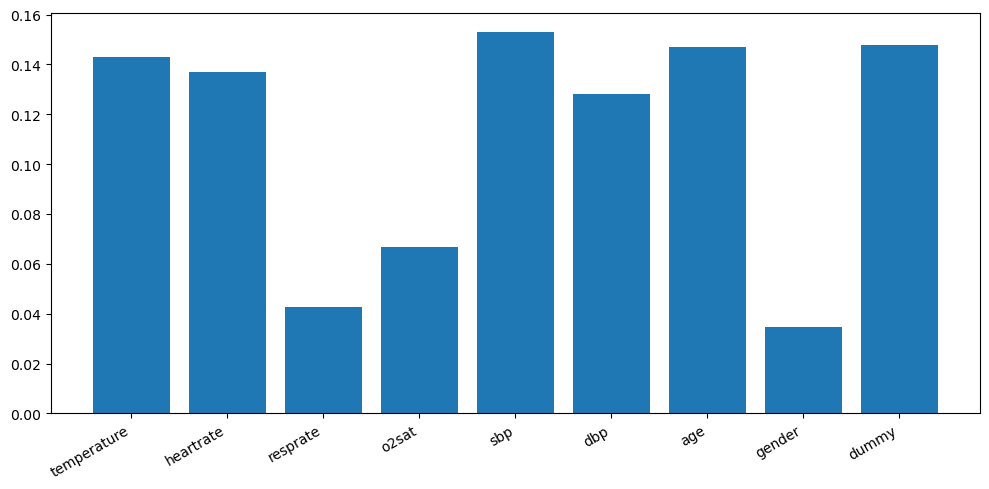

Processing original with RandomForest


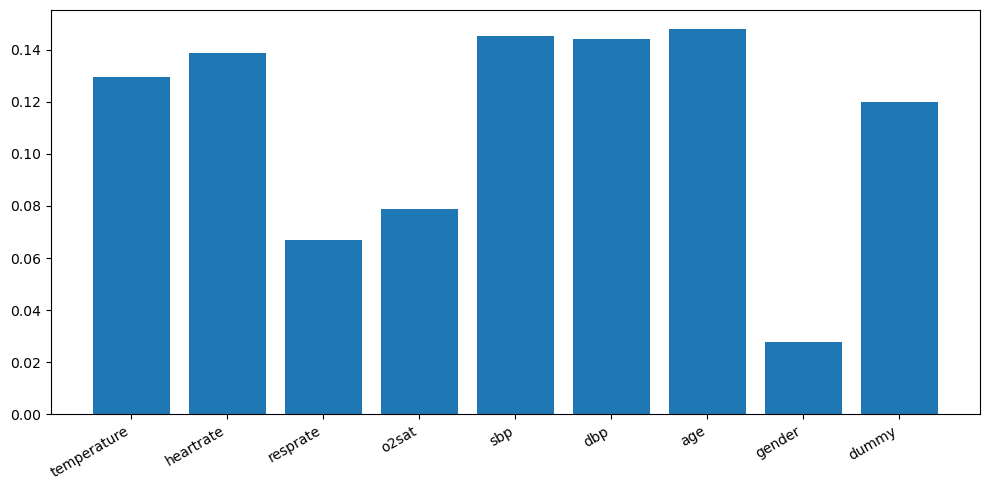

Processing original with XGBoost


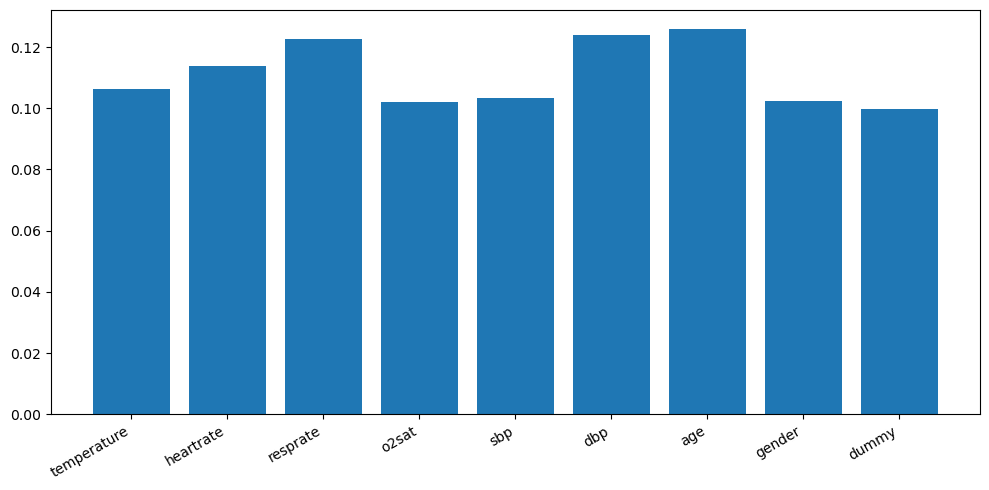

Processing original with Neural Network


c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaco

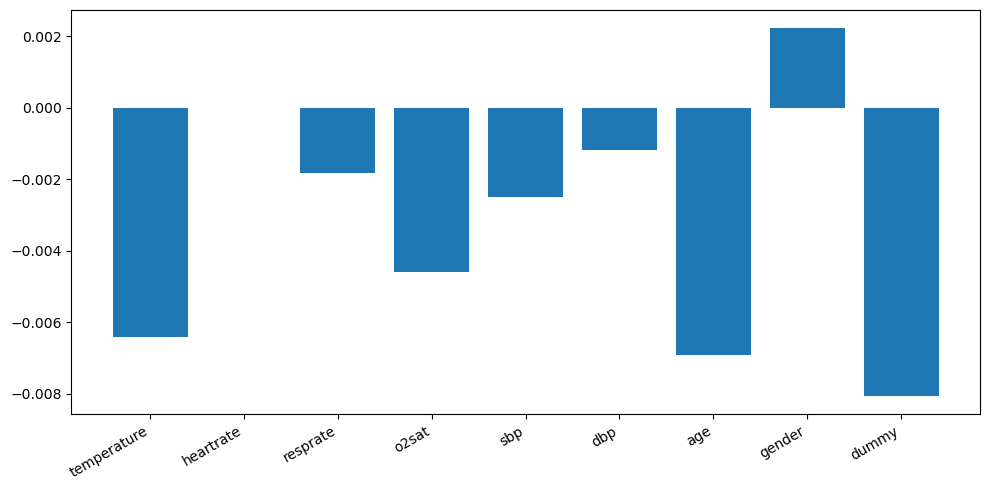

Processing llama3_augmented_with_db with DecisionTree


Processing llama3_augmented_with_db with RandomForest


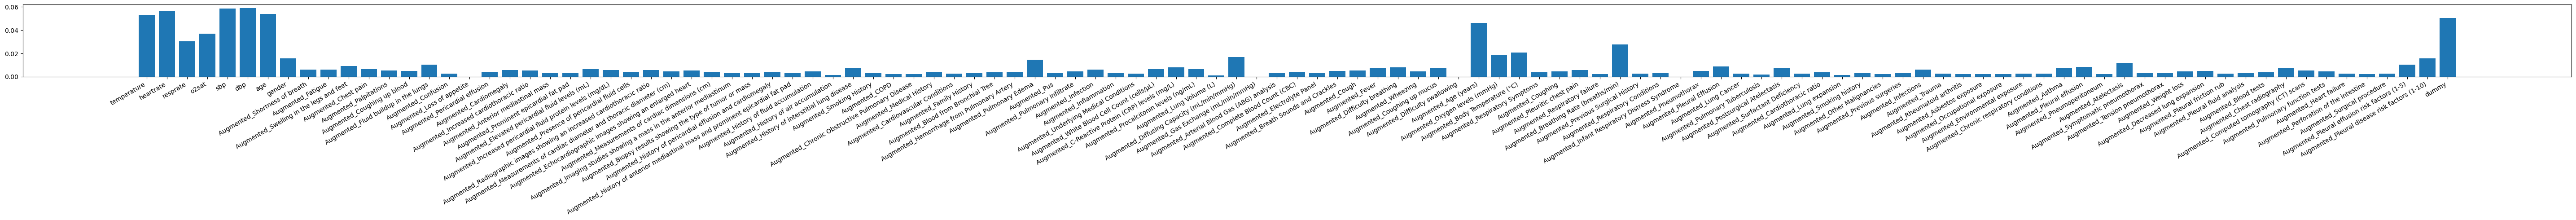

Processing llama3_augmented_with_db with XGBoost


Processing llama3_augmented_with_db with Neural Network


c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaco

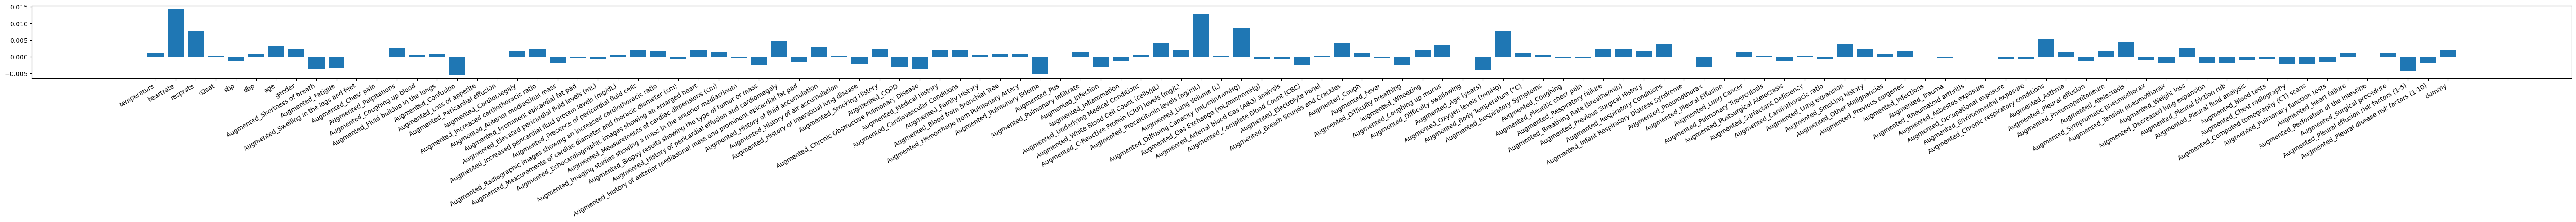

Processing llama3_augmented_without_db with DecisionTree


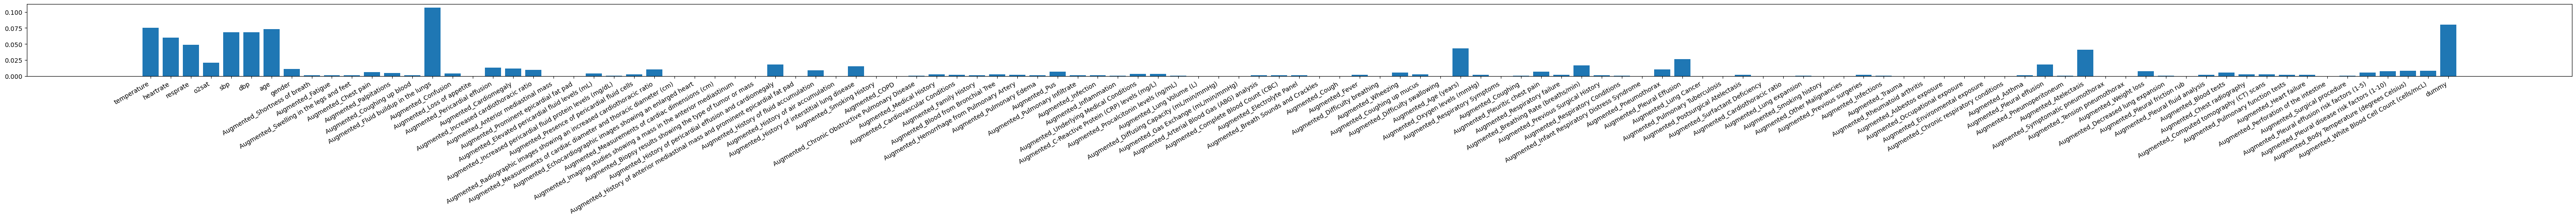

Processing llama3_augmented_without_db with RandomForest


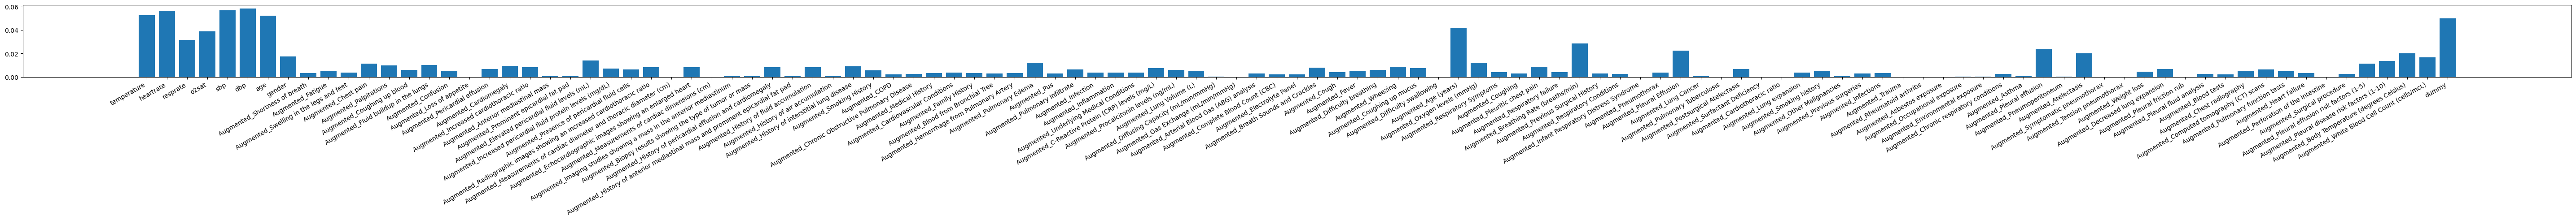

Processing llama3_augmented_without_db with XGBoost


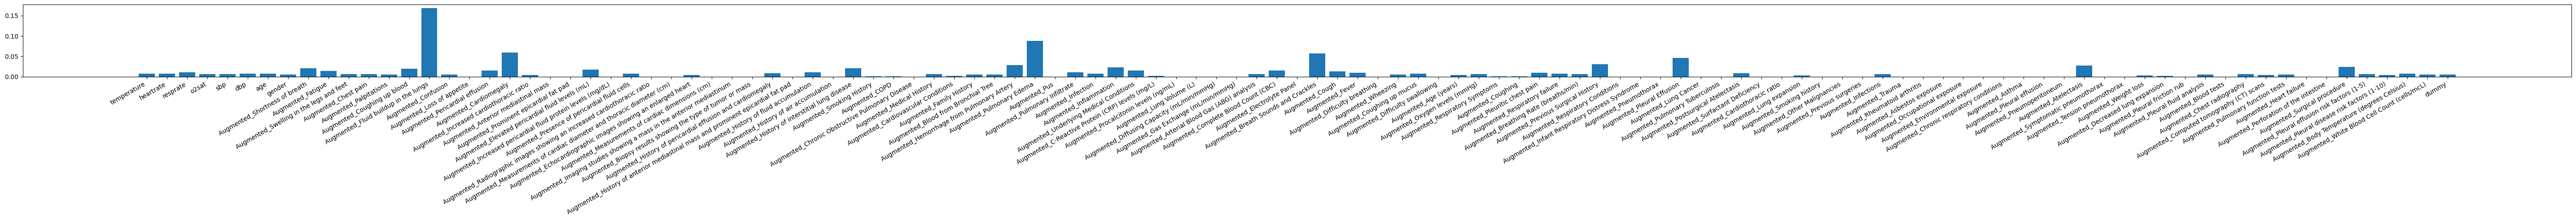

Processing llama3_augmented_without_db with Neural Network


c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaco

Processing mistral_augmented_with_db with DecisionTree


Processing mistral_augmented_with_db with RandomForest


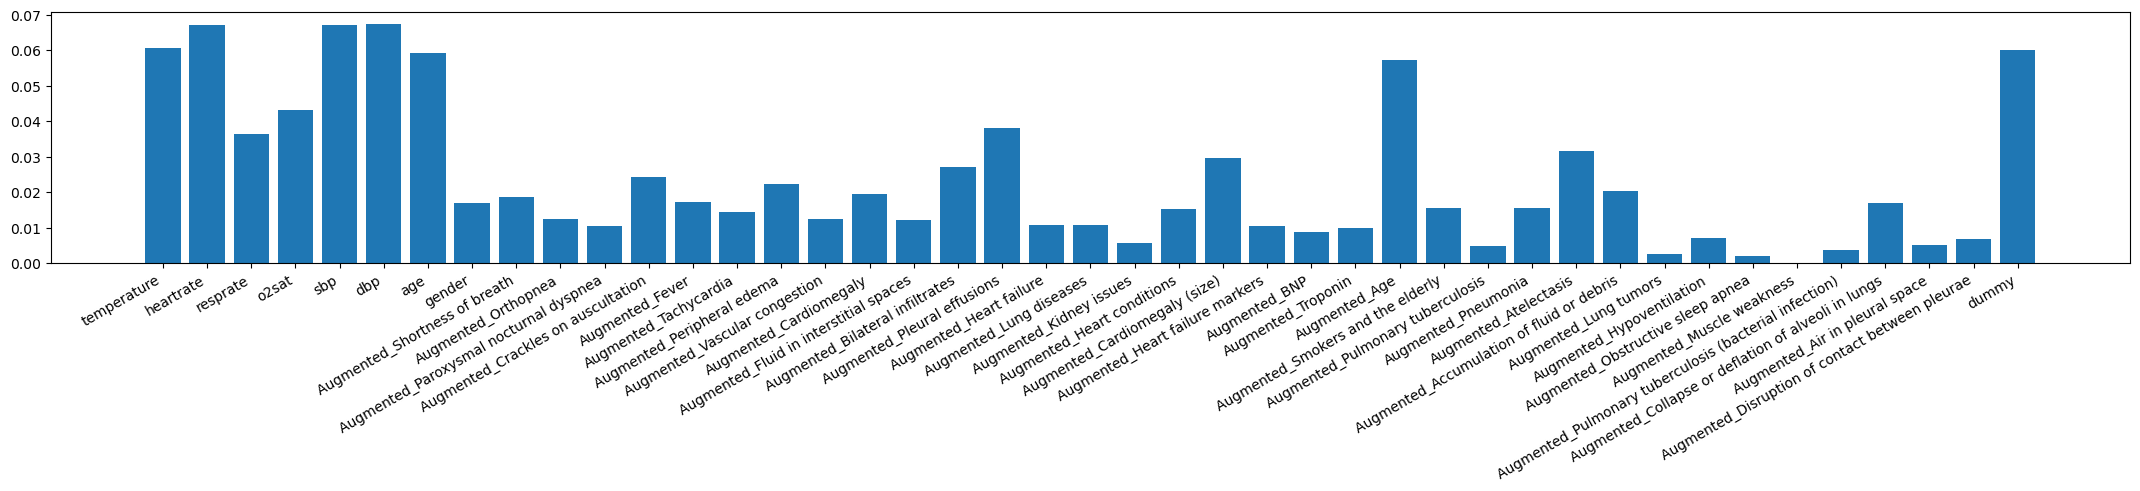

Processing mistral_augmented_with_db with XGBoost


Processing mistral_augmented_with_db with Neural Network


c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaco

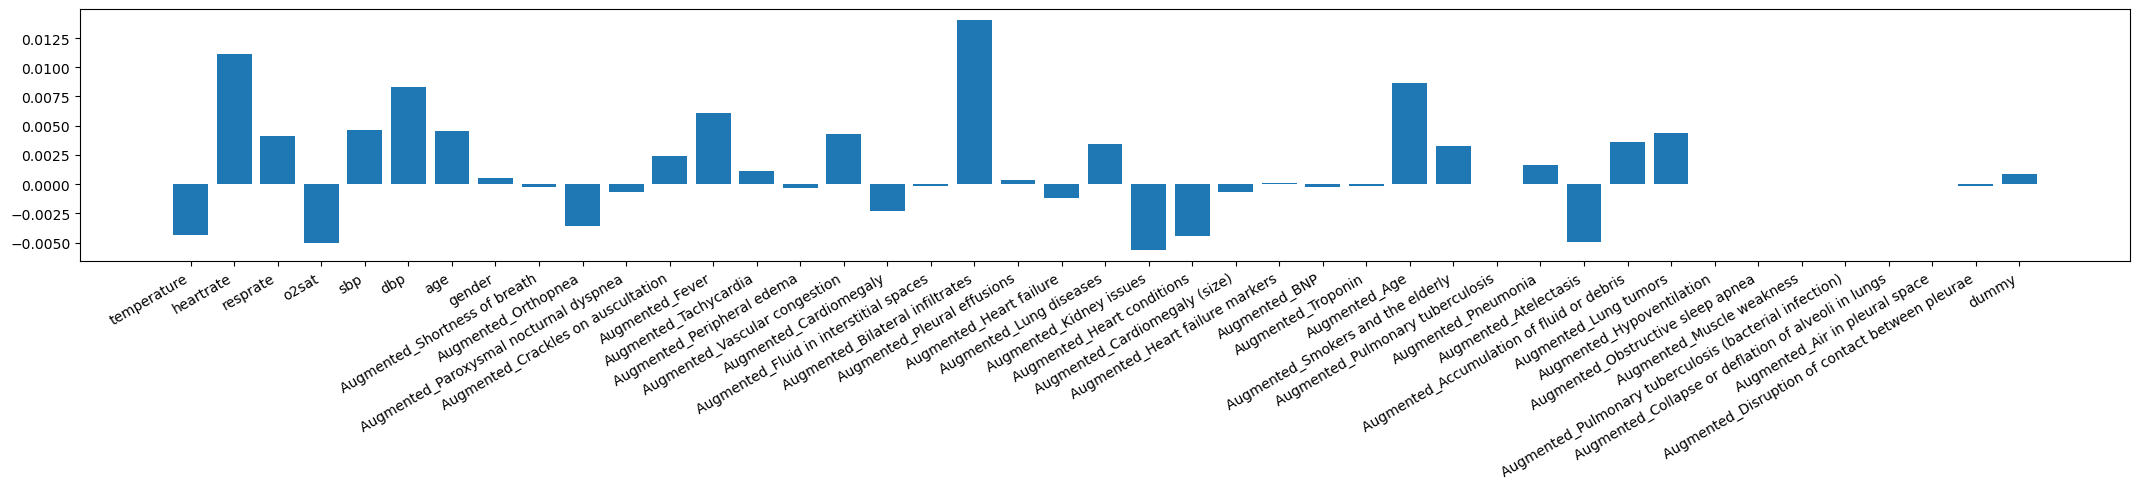

Processing mistral_augmented_without_db with DecisionTree


Processing mistral_augmented_without_db with RandomForest


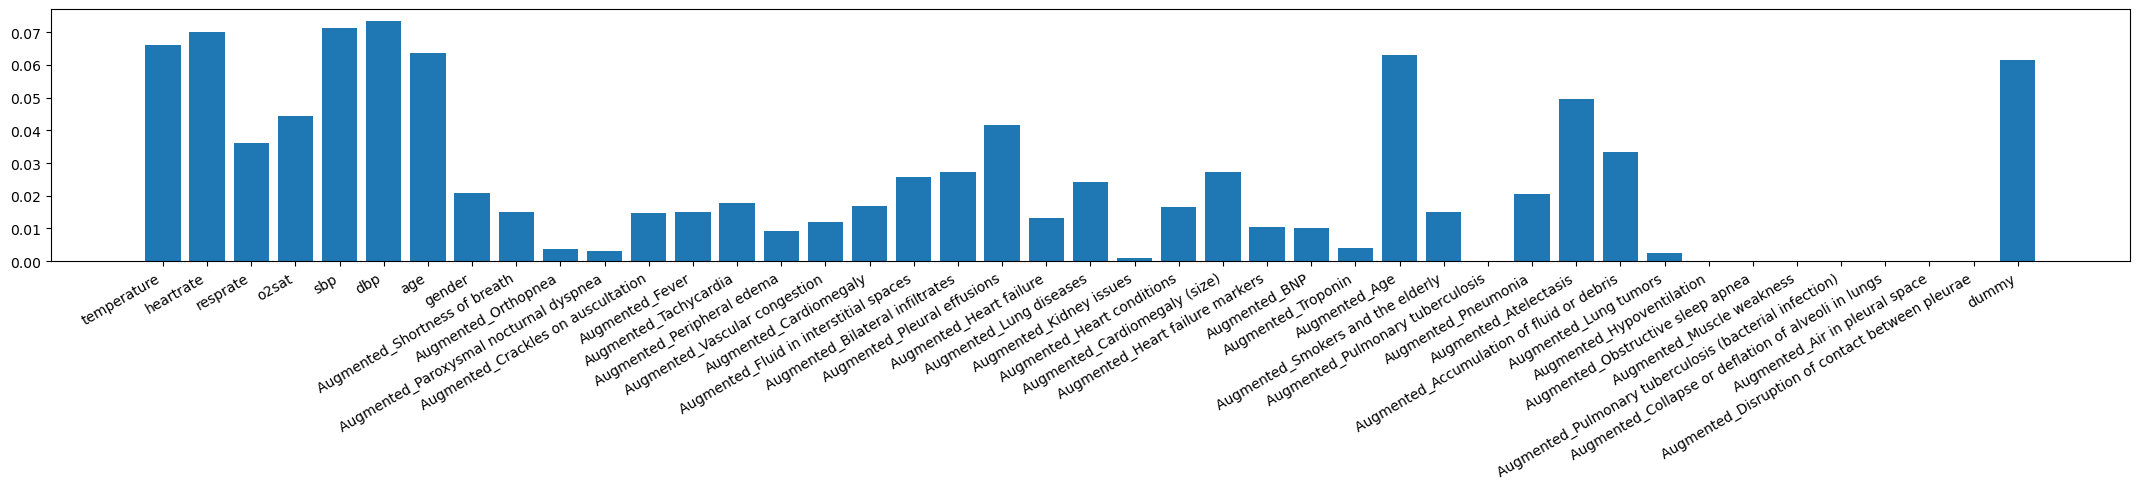

Processing mistral_augmented_without_db with XGBoost


Processing mistral_augmented_without_db with Neural Network


c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaconda3\envs\pytorch\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mike8\anaco

In [16]:
import os
import xgboost as xgb
from copy import deepcopy

save_folder = os.path.join("generated", "aug_results")
prefix = "[all-lesions] [with-doc] [trx] [nopk]"

result_df = []

llama3_keywords_json_nodb = deepcopy(llama3_keywords_json)
llama3_keywords_json_nodb["Augmented_Body Temperature (degrees Celsius)"] = (
    llama3_keywords_json_nodb["Augmented_Body Temperature (°C)"]
)
del llama3_keywords_json_nodb["Augmented_Body Temperature (°C)"]
llama3_keywords_json_nodb["Augmented_White Blood Cell Count (cells/mcL)"] = (
    llama3_keywords_json_nodb["Augmented_White Blood Cell Count (cells/μL)"]
)
del llama3_keywords_json_nodb["Augmented_White Blood Cell Count (cells/μL)"]

features_sets = {
    "original": {
        "df": llama_df_with_db,
        "cols": original_clinical_cols,
        "keywords_map": original_keywords_map,
    },
    "llama3_augmented_with_db": {
        "df": llama_df_with_db,
        "cols": original_clinical_cols + list(llama3_keywords_json.keys()),
        "keywords_map": combined_keywords_map(
            original_keywords_map, llama3_keywords_json
        ),
    },
    "llama3_augmented_without_db": {
        "df": llama_df_without_db,
        "cols": original_clinical_cols + list(llama3_keywords_json_nodb.keys()),
        "keywords_map": combined_keywords_map(
            original_keywords_map, llama3_keywords_json_nodb
        ),
    },
    "mistral_augmented_with_db": {
        "df": mistral_df_with_db,
        "cols": original_clinical_cols + list(mistral_keywords_json.keys()),
        "keywords_map": combined_keywords_map(
            original_keywords_map, mistral_keywords_json
        ),
    },
    "mistral_augmented_without_db": {
        "df": mistral_df_without_db,
        "cols": original_clinical_cols + list(mistral_keywords_json.keys()),
        "keywords_map": combined_keywords_map(
            original_keywords_map, mistral_keywords_json
        ),
    },
}


def get_mlp_classifier():
    return MLPClassifier(
        hidden_layer_sizes=(512, 256, 128, 64, 32),
        max_iter=200,
    )


models = {
    "DecisionTree": DecisionTreeClassifier,
    "RandomForest": RandomForestClassifier,
    "XGBoost": xgb.XGBClassifier,
    "Neural Network": MLPClassifier,
    # "Larger Neural Network": get_mlp_classifier,
}

# loop through datasets
for f_k, f_v in features_sets.items():
    for m_k, m_v in models.items():
        print(f"Processing {f_k} with {m_k}")
        result = get_summary(
            f_v["df"],
            f_v["cols"] + ["dummy"],
            chexpert_label_cols,
            m_v,
            f_v["keywords_map"],
        )

        # append the dataframe
        # save fig
        result["fi_fig"].savefig(
            os.path.join(save_folder, f"{prefix} [{f_k}][{m_k}].png")
        )
        result_df.append(
            OrderedDict(
                {
                    "Feature Set": f_k,
                    "Model": m_k,
                    "Accuracy": result["Accuracy"],
                    "AUC": result["AUC"],
                    "Precision": result["Precision"],
                    "F-1": result["F-1"],
                    "Recall": result["Recall"],
                    "p-value": result["p-value"],
                    "#fi>dummy": result["#fi>dummy"],
                    "#input_cols": result["#input_cols"],
                    "fi>dummy": result["fi>dummy"],
                }
            )
        )

In [17]:
# remove the index
result_df = pd.DataFrame(result_df)

In [18]:
result_df

Feature Set           Model Accuracy     AUC Precision  \
0                       original    DecisionTree   0.9210  0.5822    0.1041   
1                       original    RandomForest   0.9721  0.5485    0.6583   
2                       original         XGBoost   0.9611  0.5168    0.1071   
3                       original  Neural Network   0.9685  0.5097    0.1988   
4       llama3_augmented_with_db    DecisionTree   0.9387  0.6225    0.1722   
5       llama3_augmented_with_db    RandomForest   0.9728  0.5575    0.7198   
6       llama3_augmented_with_db         XGBoost   0.9698  0.5864    0.4615   
7       llama3_augmented_with_db  Neural Network   0.9655  0.5690    0.3132   
8    llama3_augmented_without_db    DecisionTree   0.9468  0.6006    0.1815   
9    llama3_augmented_without_db    RandomForest   0.9740  0.5820    0.7522   
10   llama3_augmented_without_db         XGBoost   0.9677  0.6287    0.4186   
11   llama3_augmented_without_db  Neural Network   0.9654  0.5935    0.3436   
12     mistral_augmented_with_db    DecisionTree   0.9398  0.6312    0.1827   
13     mistral_augmented_with_db    RandomForest   0.9739  0.5748    0.7927   
14     mistral_augmented_with_db         XGBoost   0.9697  0.6639    0.4762   
15     mistral_augmented_with_db  Neural Network   0.9663  0.5799    0.3483   
16  mistral_augmented_without_db    DecisionTree   0.9588  0.6668    0.3195   
17  mistral_augmented_without_db    RandomForest   0.9735  0.5876    0.6851   
18  mistral_augmented_without_db         XGBoost   0.9694  0.6296    0.4615   
19  mistral_augmented_without_db  Neural Network   0.9701  0.5424    0.4329   

       F-1  Recall p-value  #fi>dummy  #input_cols  \
0   0.1417  0.2224  0.0000          1            9   
1   0.1711  0.0985  0.0000          5            9   
2   0.0632  0.0448  0.0001          8            9   
3   0.0399  0.0224  0.0000          8            9   
4   0.2150  0.2866  0.0012          6          115   
5   0.2002  0.1164  0.0000          5          115   
6   0.2581  0.1791  0.0000         57          115   
7   0.2002  0.1478  0.0009         24          115   
8   0.2038  0.2328  0.1550          1          115   
9   0.2711  0.1657  0.0000          5          115   
10  0.3273  0.2687  0.0205         49          115   
11  0.2513  0.1985  0.0087         98          115   
12  0.2279  0.3034  0.0028          4           43   
13  0.2522  0.1508  0.0000          4           43   
14  0.3960  0.3390  0.0867         32           43   
15  0.2277  0.1695  0.0019         16           43   
16  0.3368  0.3567  0.5253          7           43   
17  0.2818  0.1776  0.0000          6           43   
18  0.3396  0.2687  0.0059         27           43   
19  0.1453  0.0881  0.0000         37           43   

                                             fi>dummy  
0                                               [sbp]  
1             [temperature, heartrate, sbp, dbp, age]  
2   [temperature, heartrate, resprate, o2sat, sbp,...  
3   [temperature, heartrate, resprate, o2sat, sbp,...  
4   [temperature, heartrate, sbp, dbp, age, Augmen...  
5             [temperature, heartrate, sbp, dbp, age]  
6   [heartrate, resprate, o2sat, sbp, dbp, age, Au...  
7   [heartrate, resprate, age, gender, Augmented_P...  
8              [Augmented_Fluid buildup in the lungs]  
9             [temperature, heartrate, sbp, dbp, age]  
10  [temperature, heartrate, resprate, o2sat, sbp,...  
11  [temperature, heartrate, resprate, o2sat, sbp,...  
12  [temperature, heartrate, dbp, Augmented_Pleura...  
13                 [temperature, heartrate, sbp, dbp]  
14  [temperature, heartrate, resprate, o2sat, sbp,...  
15  [heartrate, resprate, sbp, dbp, age, Augmented...  
16  [temperature, heartrate, sbp, dbp, age, Augmen...  
17  [temperature, heartrate, sbp, dbp, age, Augmen...  
18  [temperature, heartrate, resprate, o2sat, sbp,...  
19  [temperature, heartrate, resprate, o2sat, sbp,...

In [19]:
# drop index
result_df.to_csv(
    os.path.join(save_folder, f"{prefix} [result].csv"), index=False
)